In [127]:
import numpy as np
from scipy import optimize
from numba import vectorize, float32, float64
import torch
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj/')
from dft3dgpu import dft3d
from eos import LJEOS 

from pymatgen.core import Structure
from pymatgen.analysis import structure_matcher

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-05-03

In [128]:
kB = 1.380649e-23 # J/K
Rconst = 0.082057366080960 # Gas constant
NA = 6.022e23 # Avogadro number

## Solid CIF file Information

In [129]:
structure_name = 'MOF-5'
structure = Structure.from_file('../structures/'+structure_name+'.cif')
Ncell = 2
structure.make_supercell(Ncell)
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

formula:   Zn256 H768 C1536 O832
num_sites: 3392


In [130]:
coordinates = structure.cart_coords.T
L = np.array([l/Ncell for l in structure.lattice.lengths])
print('Cell dimensions: ', L)
Vcell = L[0]*L[1]*L[2]
print('Cell volume: ', Vcell)

Cell dimensions:  [25.86584 25.86584 25.86584]
Cell volume:  17305.325019903623


# Force Field for solid-fluid interaction

In [131]:
forcefield_name = 'DREIDING'
forcefield = pd.read_csv('../parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)
forcefield

,atom,sigma/AA,epsilon/kB,mass/u
0,H,2.84642,7.64893,1.00784
1,C,3.47299,47.85620,12.01070
2,N,3.26256,38.94920,14.00670
3,O,3.03315,48.15810,15.99900
4,Cu,3.11369,2.51610,63.54600
5,Zn,4.04468,27.67710,65.38000


# Fluid Information

In [132]:
# PCSAFT: Gross, J., & Sadowski, G. (2001). Industrial & Engineering Chemistry Research, 40(4), 1244–1260.
# TraPPE: M.G. Martin, and J.I. Siepmann, J. Phys. Chem. B 102, 2569-2577 (1998).
# SoftSAFT: Blas, F. J., & Vega, L. F. (1998). Industrial and Engineering Chemistry Research, 5885(1996), 660–674.
fluid_molecule = 'CH4'
epsilon = {'TraPPE': 148.0, 'PCSAFT': 150.03, 'SoftSAFT': 147.302}
sigma = {'TraPPE': 3.73, 'PCSAFT': 3.704, 'SoftSAFT': 3.722}

fluid_forcefield = 'TraPPE'
epsilonff = epsilon[fluid_forcefield] # kelvin
sigmaff = sigma[fluid_forcefield] # angstrom
mff = 16.043
# epsilonff = 10.22 # kelvin
# sigmaff = 2.58 # angstrom
# mff = 4.0026

# Create the DFT object

In [133]:
Ngrid = 32
DFT = dft3d(gridsize=np.array([Ngrid,Ngrid,Ngrid]),ljmethod='MMFA')
DFT.Set_Geometry(L)

In [134]:
DFT.GetSystemInformation()

============== The DFT 3D for LJ fluids ==============
Methods:
The grid is [32 32 32]
--- Geometry properties ---
Lx = 25.86584  A
Ly = 25.86584  A
Lz = 25.86584  A
Vol = 17305.325019903623  A³


In [135]:
DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff)

In [136]:
DFT.GetFluidInformation()

--- Fluid properties ---
epsilon/kB = 148.0  K
sigma = 3.73  A


## Defining the Temperature

In [137]:
kT = 150.0 # kelvin 
DFT.Set_Temperature(kT)

In [138]:
DFT.GetFluidTemperatureInformation()

Temperature = 150.0  K
Baker-Henderson diameter = 3.631  A


## Generating the External Potential

In [139]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

In [140]:
%%time

mss = 0.0

Vext = np.zeros((Ngrid,Ngrid,Ngrid))

# Lorentz-Berthelot combination rule
for i, site in enumerate(structure):
    sigmasf = float(0.5*(sigmaff+forcefield["sigma/AA"][forcefield["atom"]==site.species_string]))
    epsilonsf = float(np.sqrt(epsilonff*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string]))
    mss += float(forcefield["mass/u"][forcefield["atom"]==site.species_string])

    R = np.sqrt((DFT.X-structure.cart_coords[i,0]+L[0])**2 + (DFT.Y-structure.cart_coords[i,1]+L[1])**2 + (DFT.Z-structure.cart_coords[i,2]+L[2])**2)
    Vext[:] += ljpotential(R,epsilonsf,sigmasf)

mss = mss/(Ncell**3)

del R

DFT.Set_External_Potential(Vext)

CPU times: user 22.5 s, sys: 8.58 ms, total: 22.5 s
Wall time: 22.5 s


In [141]:
24*mff/(24*mff+mss)*100

5.883835202833586

In [142]:
print('Unit cell mass: ', mss, ' u')

Unit cell mass:  6158.863039999983  u


In [143]:
rhocr = 1e27*mss/(Vcell*NA) #kg/m3 crystal MOF-5 density

In [144]:
print('Crystal Density: ',rhocr,' kg/m3')

Crystal Density:  590.9898672923852  kg/m3


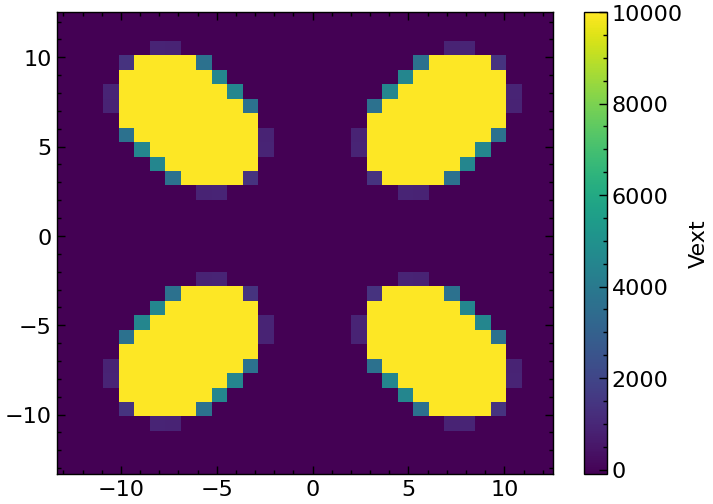

In [145]:
plt.figure(figsize=(8,6))
c=plt.pcolormesh(DFT.X[:,:,Ngrid//2],DFT.Y[:,:,Ngrid//2],DFT.Vext[:,:,Ngrid//2].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
plt.colorbar(label='Vext')
plt.show()

In [146]:
ljeos= LJEOS(sigma=sigmaff,epsilon=epsilonff,model='MBWR')

In [147]:
def rhofromBARpressure(pbar):
    def func(x,p):
        return ljeos.p(x,kT)-p,ljeos.dpdrho(x,kT), ljeos.d2pdrho2(x,kT)
    if np.isscalar(pbar):
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar/(1e-5*kB)), method='halley')
        rho = sol.root
    else:
        rho = np.empty_like(pbar)
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[0]/(1e-5*kB)), method='halley')
        rho[0] = sol.root
        for i in range(1,pbar.size):
            sol = optimize.root_scalar(func, x0=rho[i-1], fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
            rho[i] = sol.root
    return rho

In [156]:
pbararray = np.hstack((np.arange(0.01,2.0,0.1),np.arange(2.,101,1.0),np.arange(110,310,10.0))) # bulk pressure (in bar)
# pbararray = np.hstack((np.arange(0.001,2.0,0.001),np.arange(2.,101,1.0))) # bulk pressure (in bar)

In [157]:
rhobarray = rhofromBARpressure(pbararray)

Text(0, 0.5, '$\\rho_b$ (molecules/$\\AA^{3}$)')

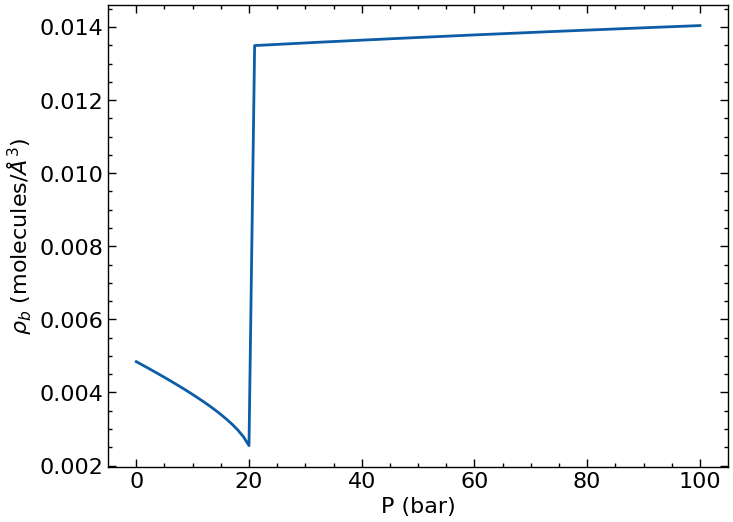

In [158]:
plt.plot(pbararray,rhobarray)
plt.xlabel(r'P (bar)')
plt.ylabel(r'$\rho_b$ (molecules/$\AA^{3}$)')

In [159]:
%%time

Nadsarray = np.zeros_like(rhobarray)

DFT.Set_BulkDensity(rhobarray[0])
DFT.Set_InitialCondition()

print('P (bar)\t rhob (AA^-3)\t Nabs(molecules/u.c.)')

for i in range(rhobarray.size):
    rhob = rhobarray[i]

    DFT.Set_BulkDensity(rhob)

    DFT.Calculate_Equilibrium(alpha0=0.25,dt=0.2,rtol=1e-4,atol=1e-6,method='fire',logoutput=False)

    Nadsarray[i] = DFT.Nadstot
    print(pbararray[i],rhob,Nadsarray[i])

P (bar)	 rhob (AA^-3)	 Nabs(molecules/u.c.)
0.001 0.004843720162788195 nan


KeyboardInterrupt: 

In [ ]:
# helium_void_fraction = Vpore/Vcell
# helium_void_fraction = 0.852
helium_void_fraction = 0.815

Vpore = helium_void_fraction*Vcell

In [ ]:
Marray = mff*Nadsarray

Nbulkarray = rhobarray*Vpore
Mbulk = mff*Nbulkarray

In [ ]:
Nidealarray = rhobarray*torch.exp(-DFT.beta*DFT.Vext[:,:,:].cpu()).sum().numpy()*DFT.dV
Midealarray = mff*Nidealarray

In [ ]:
Nexcarray = Nadsarray - Nbulkarray
Mexcarray = Nexcarray*mff

In [ ]:
df = pd.DataFrame()
df['Pressure (bar)'] = pbararray
df['Bulk adsorption (molecules/uc)'] = Nbulkarray
df['Bulk adsorption (%w.t.)'] = 100*Mbulk/(mss+Mbulk)
df['Bulk adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nbulkarray/Vcell
df['Bulk adsorption (mol/kg)'] = 1e3*Nbulkarray/mss
df['Ideal adsorption (molecules/uc)'] = Nidealarray
df['Ideal adsorption (%w.t.)'] = 100*Midealarray/(mss+Midealarray)
df['Ideal adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nidealarray/Vcell
df['Ideal adsorption (mol/kg)'] = 1e3*Nidealarray/mss
df['Absolute adsorption (molecules/uc)'] = Nadsarray
df['Absolute adsorption (mg/g)'] = 1e3*Marray/mss
df['Absolute adsorption (%w.t.)'] = 100*Marray/(mss+Marray)
df['Absolute adsorption (mol/kg)'] = 1e3*Nadsarray/mss
df['Absolute adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nadsarray/Vcell
df['Excess adsorption (molecules/uc)'] = Nexcarray
df['Excess adsorption (mg/g)'] = 1e3*Mexcarray/mss
df['Excess adsorption (%w.t.)'] = 100*Mexcarray/(mss+Mexcarray)
df['Excess adsorption (mol/kg)'] = 1e3*Nexcarray/mss
df['Excess adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nexcarray/Vcell

In [ ]:
df.head()

,Pressure (bar),Bulk adsorption (molecules/uc),Bulk adsorption (%w.t.),Bulk adsorption (cm^3 STP/cm^3),Bulk adsorption (mol/kg),Ideal adsorption (molecules/uc),Ideal adsorption (%w.t.),Ideal adsorption (cm^3 STP/cm^3),Ideal adsorption (mol/kg),Absolute adsorption (molecules/uc),Absolute adsorption (mg/g),Absolute adsorption (%w.t.),Absolute adsorption (mol/kg),Absolute adsorption (cm^3 STP/cm^3),Excess adsorption (molecules/uc),Excess adsorption (mg/g),Excess adsorption (%w.t.),Excess adsorption (mol/kg),Excess adsorption (cm^3 STP/cm^3)
0,0.01,0.005108,0.001331,0.010986,0.000829,0.261906,0.068176,0.563291,0.042525,0.260687,0.679054,0.067859,0.042327,0.560670,0.255579,0.665748,0.066531,0.041498,0.549684
1,0.51,0.261266,0.068010,0.561915,0.042421,13.396086,3.371838,28.811511,2.175091,14.471898,37.697325,3.632786,2.349768,31.125305,14.210632,37.016763,3.569543,2.307347,30.563390
2,1.01,0.518925,0.134990,1.116073,0.084257,26.607247,6.481598,57.225298,4.320156,30.103918,78.416609,7.271458,4.887902,64.745731,29.584993,77.064881,7.155083,4.803645,63.629658
3,1.51,0.778106,0.202276,1.673505,0.126339,39.896470,9.414126,85.806973,6.477895,45.941914,119.672432,10.688165,7.459480,98.809157,45.163807,117.645572,10.526197,7.333140,97.135653
4,2.00,1.033602,0.268516,2.223010,0.167823,52.996711,12.130338,113.982199,8.604950,61.340641,159.784021,13.777050,9.959735,131.927832,60.307039,157.091629,13.576421,9.791911,129.704822


(0.0, 30.0)

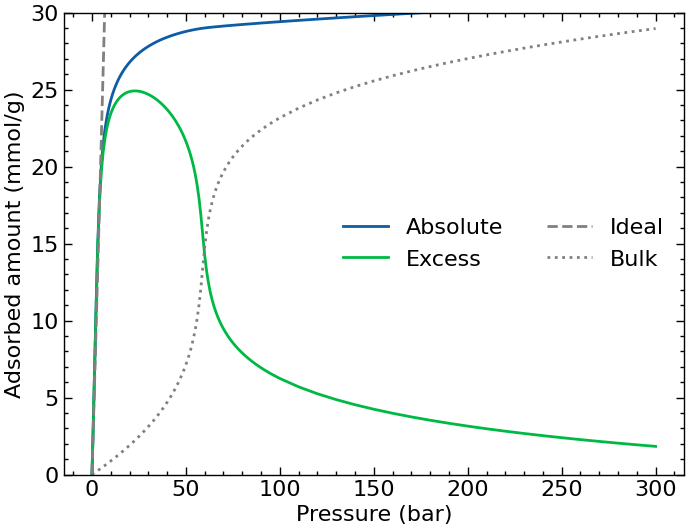

In [ ]:
plt.plot(df['Pressure (bar)'],df['Absolute adsorption (mol/kg)'],label='Absolute')
plt.plot(df['Pressure (bar)'],df['Excess adsorption (mol/kg)'],label='Excess')
plt.plot(df['Pressure (bar)'],df['Ideal adsorption (mol/kg)'],'--',color='grey',label='Ideal')
plt.plot(df['Pressure (bar)'],df['Bulk adsorption (mol/kg)'],':',color='grey',label='Bulk')
plt.legend(loc='best',ncol=2)
plt.ylabel('Adsorbed amount (mmol/g)')
plt.xlabel('Pressure (bar)')
plt.ylim(0,30)

In [ ]:
df.to_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-'+fluid_forcefield+'-'+forcefield_name+'-T='+str(kT)+'K-N='+str(Ngrid)+'-ljmethod='+str(DFT.ljmethod)+'.dat', index=False,sep='\t')

In [ ]:
dft200K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=200.0K-N=64-ljmethod=MMFA.dat',sep='\t')
dft240K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=240.0K-N=64-ljmethod=MMFA.dat',sep='\t')
dft270K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=270.0K-N=64-ljmethod=MMFA.dat',sep='\t')
dft300K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=300.0K-N=64-ljmethod=MMFA.dat',sep='\t')


dft200K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=200.0K-N=32-ljmethod=MMFA.dat',sep='\t')
dft240K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=240.0K-N=32-ljmethod=MMFA.dat',sep='\t')
dft270K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=270.0K-N=32-ljmethod=MMFA.dat',sep='\t')
dft300K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=300.0K-N=32-ljmethod=MMFA.dat',sep='\t')

# Plotting the results

In [ ]:
exp_data = pd.read_excel('data/experimental/H2andCH4-MOFandZIF-isotherm-Zhou2007.xls',sheet_name='CH4-MOF5')

(0.0, 45.0)

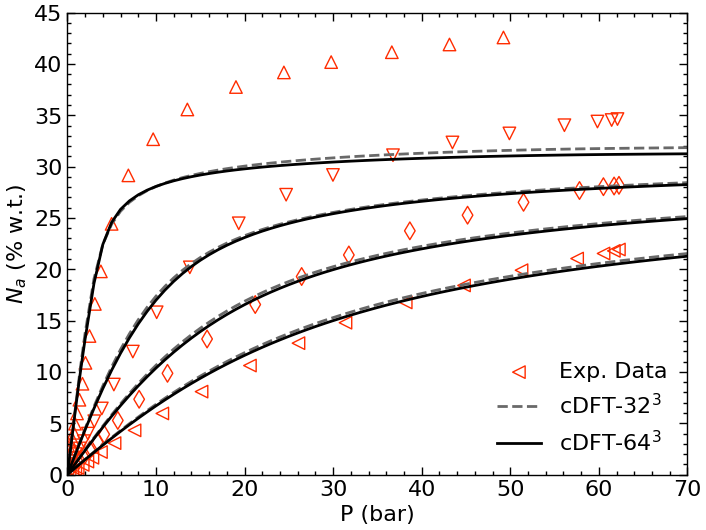

In [163]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data['P(bar)-300K'],exp_data['Na(%wt)-300K'],marker='<',edgecolors='C3',facecolors='none',label='Exp. Data')
plt.scatter(exp_data['P(bar)-270K'],exp_data['Na(%wt)-270K'],marker='d',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['P(bar)-240K'],exp_data['Na(%wt)-240K'],marker='v',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['P(bar)-200K'],exp_data['Na(%wt)-200K'],marker='^',edgecolors='C3',facecolors='none')
# plt.scatter(exp_data['P(bar)-150K'],exp_data['Na(%wt)-150K'],marker='o',edgecolors='C3',facecolors='none')

plt.plot(dft240K_data32['Pressure (bar)'],dft240K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey',label='cDFT-32$^3$')
plt.plot(dft270K_data32['Pressure (bar)'],dft270K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft300K_data32['Pressure (bar)'],dft300K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft200K_data32['Pressure (bar)'],dft200K_data32['Absolute adsorption (%w.t.)'],'--',color='dimgrey')

plt.plot(dft240K_data['Pressure (bar)'],dft240K_data['Absolute adsorption (%w.t.)'],'-',color='k',label='cDFT-64$^3$')
plt.plot(dft270K_data['Pressure (bar)'],dft270K_data['Absolute adsorption (%w.t.)'],'-',color='k')
plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Absolute adsorption (%w.t.)'],'-',color='k')
plt.plot(dft200K_data['Pressure (bar)'],dft200K_data['Absolute adsorption (%w.t.)'],'-',color='k')

# plt.plot(df['Pressure (bar)'],df['Absolute adsorption (%w.t.)'],'-',color='red')

plt.legend(loc='lower right')
plt.xlabel('P (bar)')
plt.ylabel('$N_a$ (% w.t.)')
plt.xlim(0,70)
plt.ylim(0,45)
# plt.ylim(0,20)

(0.0, 40.0)

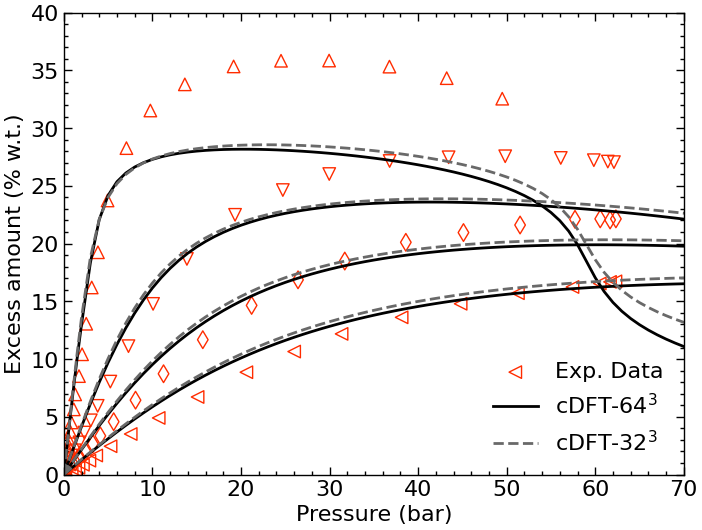

In [161]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data['Pexc(bar)-300K'],exp_data['Nexc(%wt)-300K'],marker='<',edgecolors='C3',facecolors='none',label='Exp. Data')
plt.scatter(exp_data['Pexc(bar)-270K'],exp_data['Nexc(%wt)-270K'],marker='d',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['Pexc(bar)-240K'],exp_data['Nexc(%wt)-240K'],marker='v',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['Pexc(bar)-200K'],exp_data['Nexc(%wt)-200K'],marker='^',edgecolors='C3',facecolors='none')
# plt.scatter(exp_data['Pexc(bar)-150K'],exp_data['Nexc(%wt)-150K'],marker='o',edgecolors='C3',facecolors='none')

plt.plot(dft240K_data['Pressure (bar)'],dft240K_data['Excess adsorption (%w.t.)'],'-',color='k',label='cDFT-64$^3$')
plt.plot(dft270K_data['Pressure (bar)'],dft270K_data['Excess adsorption (%w.t.)'],'-',color='k')
plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Excess adsorption (%w.t.)'],'-',color='k')
plt.plot(dft200K_data['Pressure (bar)'],dft200K_data['Excess adsorption (%w.t.)'],'-',color='k')

plt.plot(dft240K_data32['Pressure (bar)'],dft240K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey',label='cDFT-32$^3$')
plt.plot(dft270K_data32['Pressure (bar)'],dft270K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft300K_data32['Pressure (bar)'],dft300K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey')
plt.plot(dft200K_data32['Pressure (bar)'],dft200K_data32['Excess adsorption (%w.t.)'],'--',color='dimgrey')


# plt.plot(df['Pressure (bar)'],df['Excess adsorption (%w.t.)'],'-',color='red')

plt.legend(loc='lower right')
plt.xlabel('Pressure (bar)')
plt.ylabel('Excess amount (% w.t.)')
plt.xlim(0,70)
plt.ylim(0,40)

In [ ]:
exp_data2 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Duren2004.xls',sheet_name='IRMOF-1')
exp_data3 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Pillai2015.xls',sheet_name='IRMOF-1')
exp_data4 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Fu2015.xls',sheet_name='IRMOF-1')
exp_data5 = pd.read_excel('data/experimental/CH4-MOF-isotherm-Keskin2016.xls',sheet_name='IRMOF-1')

In [ ]:
def rhofromBARpressure300K(pbar):
    def func(x,p):
        return ljeos.p(x,298)-p,ljeos.dpdrho(x,298), ljeos.d2pdrho2(x,298)
    rho = np.empty_like(pbar)
    sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[0]/(1e-5*kB)), method='halley')
    rho[0] = sol.root
    for i in range(1,pbar.size):
        sol = optimize.root_scalar(func, x0=rho[i-1], fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
        rho[i] = sol.root
    return rho

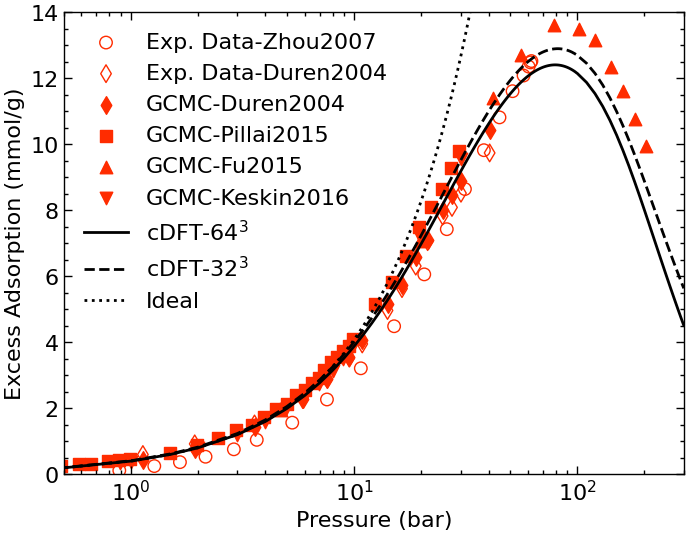

In [ ]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(exp_data['Pexc(bar)-300K'],(1e3/mss)*(mss/mff)*exp_data['Nexc(%wt)-300K']*0.01/(1-exp_data['Nexc(%wt)-300K']*0.01),marker='o',edgecolors='C3',facecolors='none',label='Exp. Data-Zhou2007')

plt.scatter(exp_data2['Pressure (atm)']/0.986923,exp_data2['Excess adsorption (cm^3 STP/cm^3)']*(1e3/mss)/(1e30*(kB*273.15/101325)/Vcell),marker='d',edgecolors='C3',facecolors='none',label='Exp. Data-Duren2004')
plt.scatter(exp_data2['Pressure (atm)']/0.986923,exp_data2['Sim Excess adsorption (cm^3 STP/cm^3)']*(1e3/mss)/(1e30*(kB*273.15/101325)/Vcell),marker='d',edgecolors='C3',facecolors='C3',label='GCMC-Duren2004')

#convert from absolute to excess
rhobarray_data3 = rhofromBARpressure300K(exp_data3['Pressure (kPa)']/100)
Nabs_data3 = exp_data3['Absolute adsorption (mmol/g)']/(1e3/mss)
Nexc_data3 = Nabs_data3 - rhobarray_data3*Vpore
plt.scatter(exp_data3['Pressure (kPa)']/100,1e3*Nexc_data3/mss,marker='s',edgecolors='C3',facecolors='C3',label='GCMC-Pillai2015')

#convert from absolute to excess
rhobarray_data4 = rhofromBARpressure300K(exp_data4['Pressure (bar)'])
Nabs_data4 = exp_data4['Absolute adsorption (cm^3 STP/cm^3)']/(1e30*(kB*273.15/101325)/Vcell)
Nexc_data4 = Nabs_data4 - rhobarray_data4*Vpore
plt.scatter(exp_data4['Pressure (bar)'],1e3*Nexc_data4/mss,marker='^',edgecolors='C3',facecolors='C3',label='GCMC-Fu2015')
plt.scatter(exp_data5['Pressure (bar)'],exp_data5['Excess adsorption (mmol/g)'],marker='v',edgecolors='C3',facecolors='C3',label='GCMC-Keskin2016')

plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Excess adsorption (mol/kg)'],'-',color='k',label='cDFT-64$^3$')

plt.plot(dft300K_data32['Pressure (bar)'],dft300K_data32['Excess adsorption (mol/kg)'],'--',color='k',label='cDFT-32$^3$')

plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Ideal adsorption (mol/kg)']-dft300K_data['Bulk adsorption (mol/kg)'],':',color='k',label='Ideal')

# plt.plot(df['Pressure (bar)'],df['Excess adsorption (mol/kg)'],'-',color='red',label='New')

plt.legend(loc='upper left')
plt.xlabel('Pressure (bar)')
plt.ylabel('Excess Adsorption (mmol/g)')
plt.xlim(0.5,300)
plt.ylim(0,14)
# plt.yscale('log')
plt.xscale('log')